In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# algorithm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline
     

In [158]:
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

In [159]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [160]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\Vincent.Cheng\AppData\Local\Continuum\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


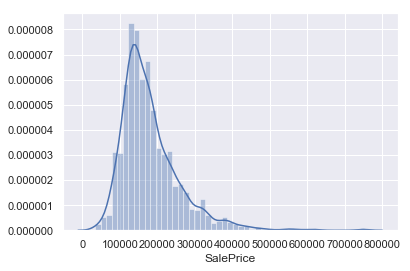

In [161]:
sns.distplot(train['SalePrice'])

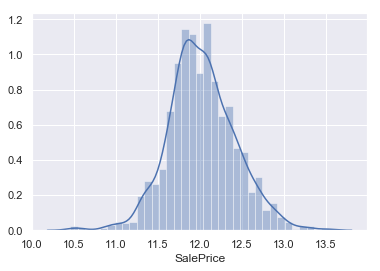

In [162]:
sns.distplot(np.log1p(train['SalePrice']))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


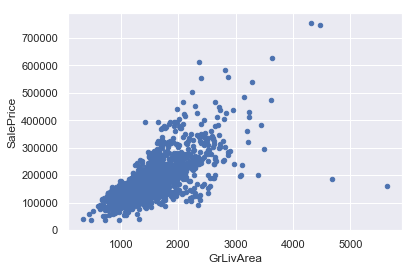

In [163]:
var = 'GrLivArea'
train.plot.scatter(x = var, y = 'SalePrice')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


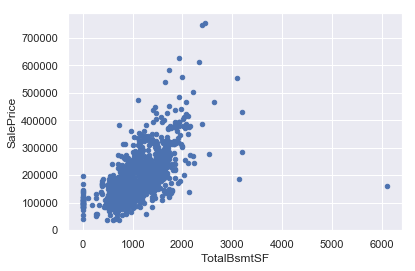

In [164]:
var = 'TotalBsmtSF'
train.plot.scatter(x = var, y = 'SalePrice')

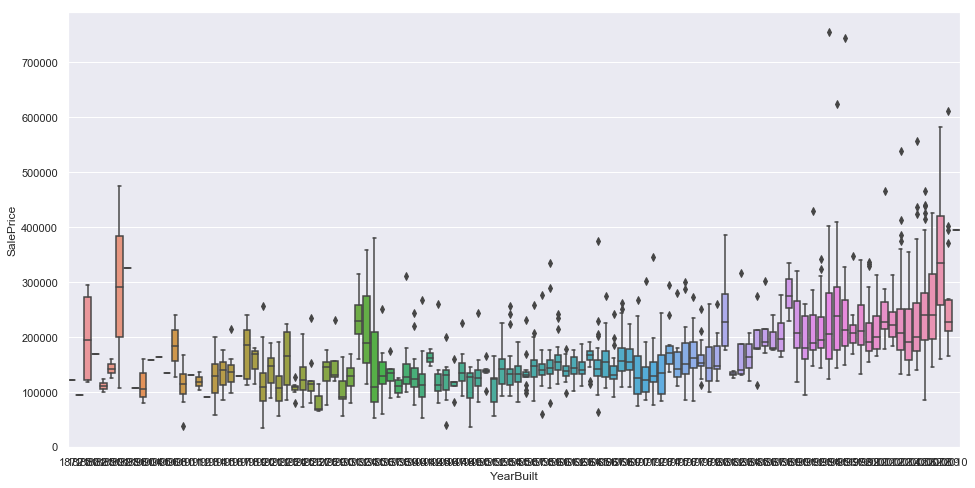

In [165]:
f, ax = plt.subplots(figsize = (16,8))
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data = train)

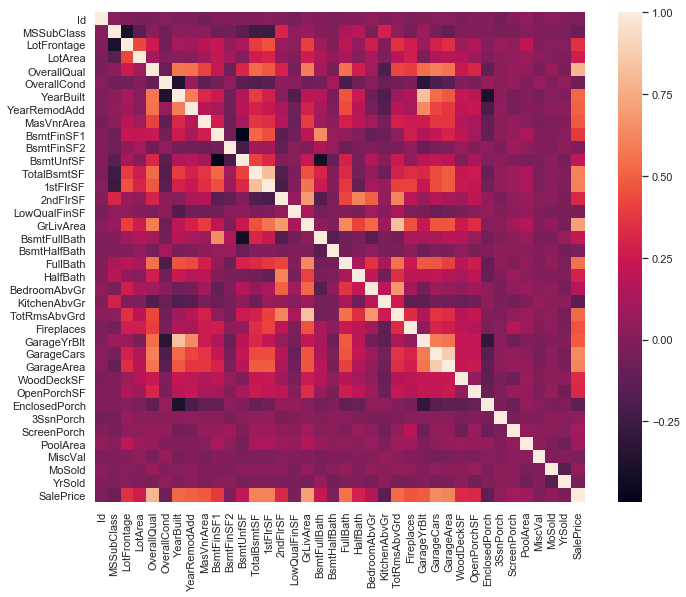

In [166]:
corrmat = train.corr()
f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, square = True)

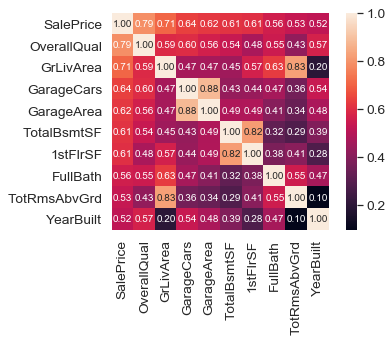

In [167]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size':10},
                 yticklabels = cols.values, xticklabels=cols.values)


C:\Users\Vincent.Cheng\AppData\Local\Continuum\anaconda\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


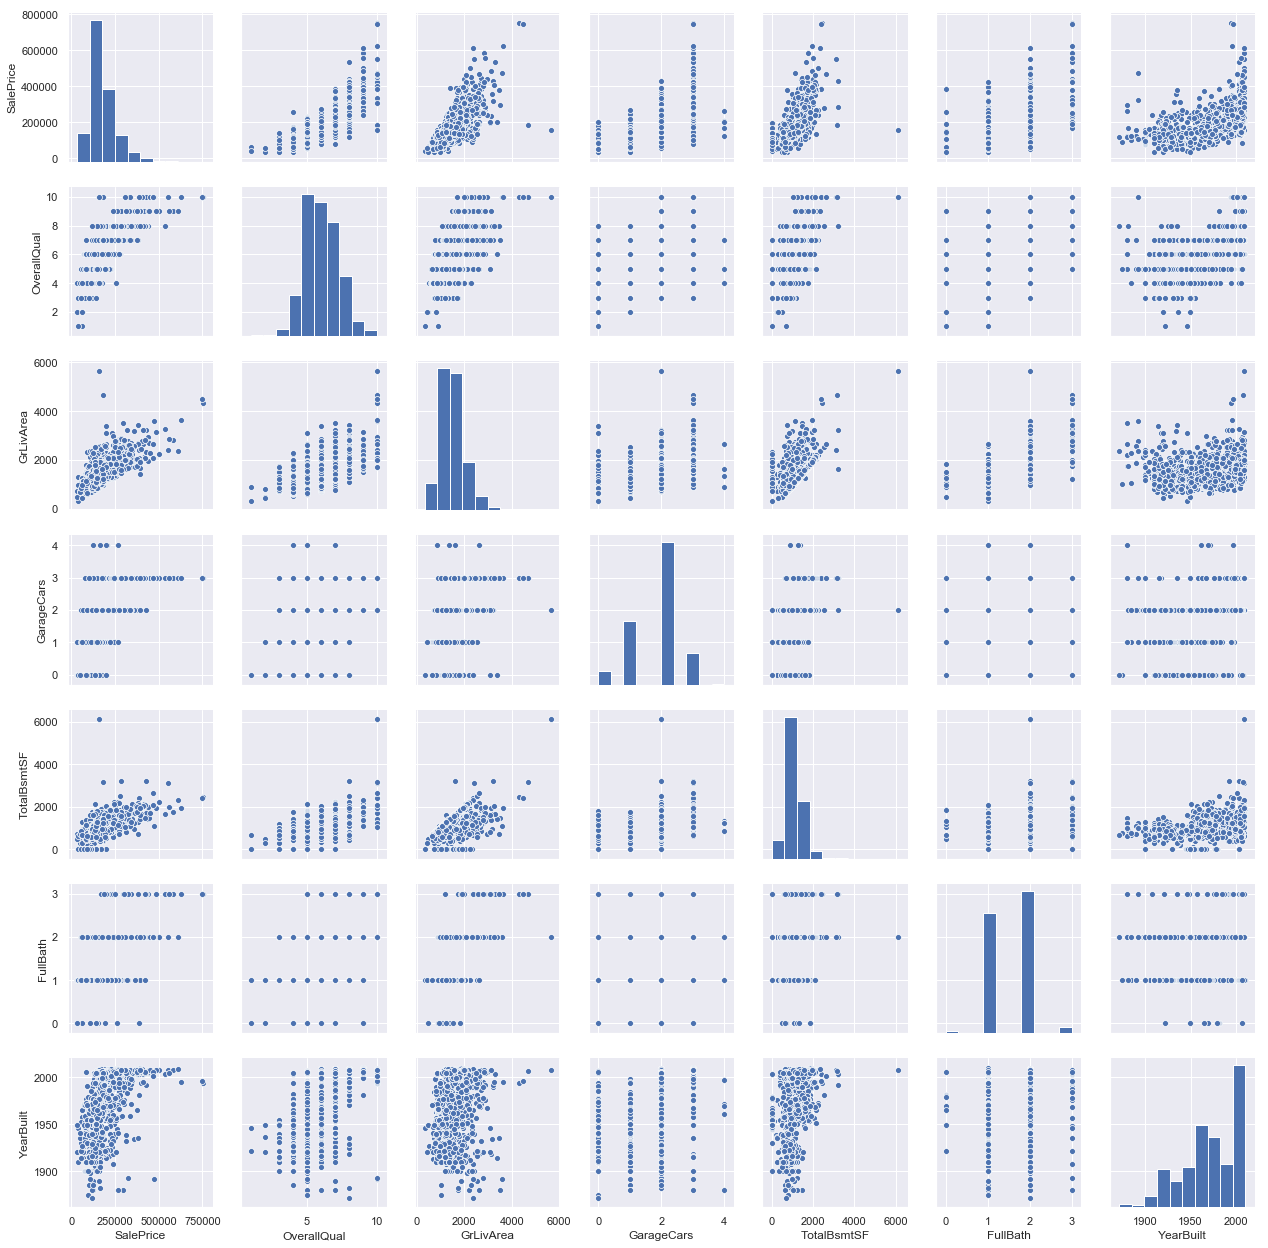

In [168]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.pairplot(train[cols],size = 2.5)

In [169]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent],axis = 1, keys = ['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [170]:
# log transforms
#     adding HasBsmt
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index = train.index)
train['HasBsmt'] = 0
train.loc[train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1 
train.loc[train['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

#    saleprice transform
train['SalePrice'] = np.log(train['SalePrice'])

# imputing with None
train['PoolQC'].fillna(value = 'None', inplace = True)
train['Alley'].fillna(value = "None", inplace = True )

C:\Users\Vincent.Cheng\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [171]:
# log transforms
#     adding HasBsmt
test['HasBsmt'] = pd.Series(len(test['TotalBsmtSF']), index = test.index)
test['HasBsmt'] = 0
test.loc[train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1 
test.loc[train['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(test['TotalBsmtSF'])

#    saleprice transform
# test['SalePrice'] = np.log(test['SalePrice'])

# imputing with None
test['PoolQC'].fillna(value = 'None', inplace = True)
test['Alley'].fillna(value = "None", inplace = True )

C:\Users\Vincent.Cheng\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


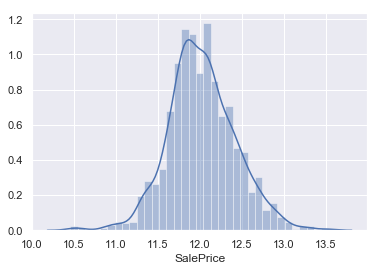

In [172]:
sns.distplot(train['SalePrice'])

In [173]:
import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)



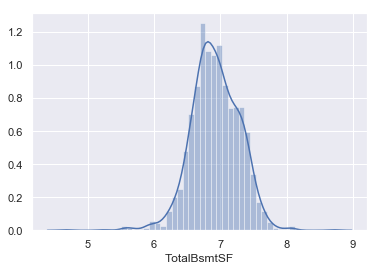

In [174]:
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'])

In [175]:
train.loc[:,('TotalBsmtSF','SalePrice')]

,TotalBsmtSF,SalePrice
0,6.752270,12.247694
1,7.140453,12.109011
2,6.824374,12.317167
3,6.628041,11.849398
4,7.043160,12.429216
5,6.679599,11.870600
6,7.430114,12.634603
7,7.009409,12.206073
8,6.858565,11.774520
9,6.898715,11.678440


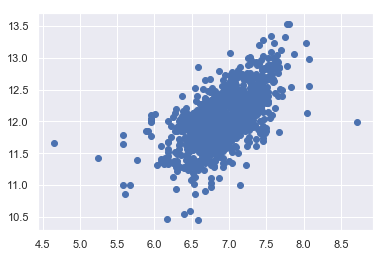

In [176]:
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);

In [177]:
train_dummies = pd.get_dummies(train)
clean_dataset(train_dummies)
train_dummies

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,0,0,1,0,0,0,0,1,0
10,11,20,70.0,11200,5,5,1965,1965,0.0,906,...,0,0,0,1,0,0,0,0,1,0


In [178]:
test.loc[960, "PoolQC"] = "Fa"
test.loc[1043, "PoolQC"] = "Gd"
test.loc[1139, "PoolQC"] = "Fa"

# Garage
test.loc[666, "GarageYrBlt"] = 1979
test.loc[1116, "GarageYrBlt"] = 1979

test.loc[666, "GarageFinish"] = "Unf"
test.loc[1116, "GarageFinish"] = "Unf"

test.loc[1116, "GarageCars"] = 2
test.loc[1116, "GarageArea"] = 480

test.loc[666, "GarageQual"] = "TA"
test.loc[1116, "GarageQual"] = "TA"

test.loc[666, "GarageCond"] = "TA"
test.loc[1116, "GarageCond"] = "TA"
# PoolQC
train = train.fillna({"PoolQC": "None"})
test = test.fillna({"PoolQC": "None"})

# Alley
train = train.fillna({"Alley": "None"})
test = test.fillna({"Alley": "None"})

# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
test = test.fillna({"FireplaceQu": "None"})

# LotFrontage
train = train.fillna({"LotFrontage": 0})
test = test.fillna({"LotFrontage": 0})

# Garage
train = train.fillna({"GarageType": "None"})
test = test.fillna({"GarageType": "None"})
train = train.fillna({"GarageYrBlt": 0})
test = test.fillna({"GarageYrBlt": 0})
train = train.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageCars": 0})
test = test.fillna({"GarageArea": 0})
train = train.fillna({"GarageQual": "None"})
test = test.fillna({"GarageQual": "None"})
train = train.fillna({"GarageCond": "None"})
test = test.fillna({"GarageCond": "None"})

# Bsmt
train = train.fillna({"BsmtQual": "None"})
test = test.fillna({"BsmtQual": "None"})
train = train.fillna({"BsmtCond": "None"})
test = test.fillna({"BsmtCond": "None"})
train = train.fillna({"BsmtExposure": "None"})
test = test.fillna({"BsmtExposure": "None"})
train = train.fillna({"BsmtFinType1": "None"})
test = test.fillna({"BsmtFinType1": "None"})
train = train.fillna({"BsmtFinSF1": 0})
test = test.fillna({"BsmtFinSF1": 0})
train = train.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinSF2": 0})
test = test.fillna({"BsmtUnfSF": 0})
test = test.fillna({"TotalBsmtSF": 0})
test = test.fillna({"BsmtFullBath": 0})
test = test.fillna({"BsmtHalfBath": 0})

# MasVnr
train = train.fillna({"MasVnrType": "None"})
test = test.fillna({"MasVnrType": "None"})
train = train.fillna({"MasVnrArea": 0})
test = test.fillna({"MasVnrArea": 0})

# MiscFeature,Fence,Utilities
# train = train.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
# test = test.drop(["Fence", "MiscFeature", "Utilities"], axis=1)

# other
test = test.fillna({"MSZoning": "RL"})
test = test.fillna({"Exterior1st": "VinylSd"})
test = test.fillna({"Exterior2nd": "VinylSd"})
train = train.fillna({"Electrical": "SBrkr"})
test = test.fillna({"KitchenQual": "TA"})
test = test.fillna({"Functional": "Typ"})
test = test.fillna({"SaleType": "WD"})
lfmean = test['LotFrontage'].mean()
test['LotFrontage'].fillna(value = lfmean)

test_dummies = pd.get_dummies(test)
test_dummies



,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0
5,1466,60,75.0,10000,6,5,1993,1994,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
6,1467,20,0.0,7980,6,7,1992,2007,0.0,935.0,...,0,0,0,1,0,0,0,0,1,0
7,1468,60,63.0,8402,6,5,1998,1998,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
8,1469,20,85.0,10176,7,5,1990,1990,0.0,637.0,...,0,0,0,1,0,0,0,0,1,0
9,1470,20,70.0,8400,4,5,1970,1970,0.0,804.0,...,0,0,0,1,0,0,0,0,1,0


In [179]:
# train_dummies.loc[960, "PoolQC"] = "Fa"
train_dummies.loc[1043, "PoolQC"] = "Gd"
train_dummies.loc[1139, "PoolQC"] = "Fa"
 
# Garage
# train_dummies.loc[666, "GarageYrBlt"] = 1979
# train_dummies.loc[1116, "GarageYrBlt"] = 1979
 
# train_dummies.loc[666, "GarageFinish"] = "Unf"
# train_dummies.loc[1116, "GarageFinish"] = "Unf"
 
# train_dummies.loc[1116, "GarageCars"] = 2
# train_dummies.loc[1116, "GarageArea"] = 480
 
# train_dummies.loc[666, "GarageQual"] = "TA"
# train_dummies.loc[1116, "GarageQual"] = "TA"
 
# train_dummies.loc[666, "GarageCond"] = "TA"
# train_dummies.loc[1116, "GarageCond"] = "TA"
# PoolQC
train = train.fillna({"PoolQC": "None"})
train_dummies = train_dummies.fillna({"PoolQC": "None"})
 
# Alley
train = train.fillna({"Alley": "None"})
train_dummies = train_dummies.fillna({"Alley": "None"})
 
# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
train_dummies = train_dummies.fillna({"FireplaceQu": "None"})
 
# LotFrontage
train = train.fillna({"LotFrontage": 0})
train_dummies = train_dummies.fillna({"LotFrontage": 0})
 
# Garage
train = train.fillna({"GarageType": "None"})
train_dummies = train_dummies.fillna({"GarageType": "None"})
train = train.fillna({"GarageYrBlt": 0})
train_dummies = train_dummies.fillna({"GarageYrBlt": 0})
train = train.fillna({"GarageFinish": "None"})
train_dummies = train_dummies.fillna({"GarageFinish": "None"})
train_dummies = train_dummies.fillna({"GarageCars": 0})
train_dummies = train_dummies.fillna({"GarageArea": 0})
train = train.fillna({"GarageQual": "None"})
train_dummies = train_dummies.fillna({"GarageQual": "None"})
train = train.fillna({"GarageCond": "None"})
train_dummies = train_dummies.fillna({"GarageCond": "None"})
 
# Bsmt
train = train.fillna({"BsmtQual": "None"})
train_dummies = train_dummies.fillna({"BsmtQual": "None"})
train = train.fillna({"BsmtCond": "None"})
train_dummies = train_dummies.fillna({"BsmtCond": "None"})
train = train.fillna({"BsmtExposure": "None"})
train_dummies = train_dummies.fillna({"BsmtExposure": "None"})
train = train.fillna({"BsmtFinType1": "None"})
train_dummies = train_dummies.fillna({"BsmtFinType1": "None"})
train = train.fillna({"BsmtFinSF1": 0})
train_dummies = train_dummies.fillna({"BsmtFinSF1": 0})
train = train.fillna({"BsmtFinType2": "None"})
train_dummies = train_dummies.fillna({"BsmtFinType2": "None"})
train_dummies = train_dummies.fillna({"BsmtFinSF2": 0})
train_dummies = train_dummies.fillna({"BsmtUnfSF": 0})
train_dummies = train_dummies.fillna({"TotalBsmtSF": 0})
train_dummies = train_dummies.fillna({"BsmtFullBath": 0})
train_dummies = train_dummies.fillna({"BsmtHalfBath": 0})
 
# MasVnr
train = train.fillna({"MasVnrType": "None"})
train_dummies = train_dummies.fillna({"MasVnrType": "None"})
train = train.fillna({"MasVnrArea": 0})
train_dummies = train_dummies.fillna({"MasVnrArea": 0})
 
# MiscFeature,Fence,Utilities
# train = train.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
# train_dummies = train_dummies.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
 
# other
train_dummies = train_dummies.fillna({"MSZoning": "RL"})
train_dummies = train_dummies.fillna({"Exterior1st": "VinylSd"})
train_dummies = train_dummies.fillna({"Exterior2nd": "VinylSd"})
train = train.fillna({"Electrical": "SBrkr"})
train_dummies = train_dummies.fillna({"KitchenQual": "TA"})
train_dummies = train_dummies.fillna({"Functional": "Typ"})
train_dummies = train_dummies.fillna({"SaleType": "WD"})
lfmean = train_dummies['LotFrontage'].mean()
train_dummies['LotFrontage'].fillna(value = lfmean)


dropcols = list(set(list(train_dummies.columns))-set(list(test_dummies.columns)))
dropcols.append('SalePrice')

train_notarg = train_dummies.drop(dropcols,axis = 1)
y = train_dummies['SalePrice']


In [180]:
train_notarg[train_notarg==np.inf]=np.nan
train_notarg.fillna(train_notarg.mean(), inplace=True)


In [181]:
dropcols = list(set(list(test_dummies.columns))-set(list(train_notarg.columns)))
dropcols

['GarageCond_None',
 'BsmtFinType1_None',
 'BsmtExposure_None',
 'FireplaceQu_None',
 'BsmtQual_None',
 'BsmtFinType2_None',
 'GarageQual_None',
 'GarageType_None',
 'BsmtCond_None',
 'GarageFinish_None']

In [182]:
rr = Ridge(alpha=10)

rr.fit(train_notarg, y)
np.sqrt(-cross_val_score(rr, train_notarg, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.1426405598247173

In [196]:
# test_dummies.drop(dropcols,axis = 1,inplace = True )
test_dummies[test_dummies==np.inf]=np.nan
test_dummies.fillna(test_dummies.mean(), inplace=True)
test_dummies.fillna(0,inplace= True)

noinf = test_dummies.replace(-np.Inf, 0)

y_pred = rr.predict(noinf)

ValueError: x and y must be the same size

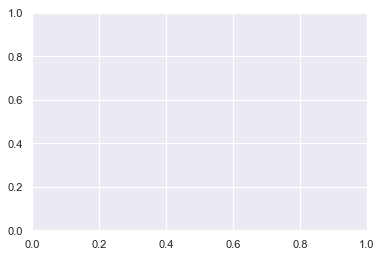

In [197]:
plt.scatter(y,y_pred)

plt.plot(range(10, 15), range(10, 15), color="red")

In [200]:
submission = np.exp(np.array((y_pred)))-1
solution = pd.DataFrame({"id":noinf.Id, "SalePrice":submission})
solution.to_csv("housepred.csv", index = False)

In [199]:
np.exp(np.array((y_pred)))-1

array([112955.13436419, 142279.80084486, 170169.12752266, ...,
       154067.82957143, 128635.47787805, 216519.97480684])

In [ ]:
numcols = test_dummies.describe().columns

from sklearn.preprocessing import Imputer

def replace_missing_value(df, number_features):

    imputer = Imputer(strategy="median")
    df_num = df[number_features]
    imputer.fit(df_num)
    X = imputer.transform(df_num)
    res_def = pd.DataFrame(X, columns=df_num.columns)
    return res_def

replace_missing_value(test_dummies,numcols)

In [ ]:
colcomp = pd.DataFrame(test_dummies.dtypes == train_notarg.dtypes)
chdt = colcomp[colcomp[0] == False]

In [ ]:
change = list(chdt.index)
train_notarg[change].dtypes

In [ ]:
test_dummies[change].dtypes

In [ ]:
def changetypes(df):
    for i in change:
        df[i] = df[i].astype(np.int64)
        
changetypes(test_dummies)


In [195]:
noinf.select_dtypes(include='float64')

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,80.0,0.0,468.0,144.0,270.0,6.782192,0.0,0.0,1961.0,1.0,730.0
1,81.0,108.0,923.0,0.0,406.0,7.192182,0.0,0.0,1958.0,1.0,312.0
2,74.0,0.0,791.0,0.0,137.0,6.833032,0.0,0.0,1997.0,2.0,482.0
3,78.0,20.0,602.0,0.0,324.0,6.830874,0.0,0.0,1998.0,2.0,470.0
4,43.0,0.0,263.0,0.0,1017.0,7.154615,0.0,0.0,1992.0,2.0,506.0
5,75.0,0.0,0.0,0.0,763.0,6.637258,0.0,0.0,1993.0,2.0,440.0
6,0.0,0.0,935.0,0.0,233.0,7.063048,1.0,0.0,1992.0,2.0,420.0
7,63.0,0.0,0.0,0.0,789.0,6.670766,0.0,0.0,1998.0,2.0,393.0
8,85.0,0.0,637.0,0.0,663.0,7.170120,1.0,0.0,1990.0,2.0,506.0
9,70.0,0.0,804.0,78.0,0.0,6.782192,1.0,0.0,1970.0,2.0,525.0


In [ ]:
train_notarg.describe()